## Análisis de Datos Mensuales del Dataframe Tarifas

### Modulos

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import itertools
import datetime

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and utilities
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Feature engineering
from feature_engine.encoding import CountFrequencyEncoder

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report

# Typing
from typing import List

## DATA UPLOAD

In [ ]:
df_tarifas = pd.read_csv(r"Tarifas 5.0.csv", parse_dates=['fecha'])

In [ ]:
df_ipc = pd.read_csv(r"IPC.csv", delimiter=';')

In [ ]:
df_priceGas = pd.read_csv(r"precios_gasoleo.csv", delimiter=';')

In [ ]:
df_priceGas['value'] = df_priceGas['value'].str.replace(',', '.')
df_priceGas['value'] = df_priceGas['value'].astype(float)

In [ ]:
df_tarifas.head()

,id_pais_origen,region_origen,provincia_origen,id_pais_destino,region_destino,provincia_destino,incoterms,id_tipo_transporte,numero_pales,fecha,precio
0,ES,6,Badajoz,ES,30,Murcia,DAP,1,0.0,2023-10-04,650.0
1,ES,6,Badajoz,ES,30,Murcia,DAP,1,0.0,2023-10-05,650.0
2,ES,6,Badajoz,ES,30,Murcia,DAP,1,0.0,2023-10-06,650.0
3,ES,6,Badajoz,ES,30,Murcia,DAP,1,0.0,2023-10-07,650.0
4,ES,6,Badajoz,ES,30,Murcia,DAP,1,0.0,2023-10-08,650.0


In [ ]:
df_tarifas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2135038 entries, 0 to 2135037
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id_pais_origen      object        
 1   region_origen       int64         
 2   provincia_origen    object        
 3   id_pais_destino     object        
 4   region_destino      int64         
 5   provincia_destino   object        
 6   incoterms           object        
 7   id_tipo_transporte  int64         
 8   numero_pales        float64       
 9   fecha               datetime64[ns]
 10  precio              float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 179.2+ MB


#### Cambio de tipo de dato según se requiera

In [ ]:
# Convert a data type to another
def type_convert(df: pd.DataFrame, type: str, convertTo: str):
    list_col = df.columns[df.dtypes == type].tolist()
    df[list_col] = df[list_col].astype(convertTo)

In [ ]:
type_convert(df_tarifas, 'object', 'string')

#### Filas y columnas en el dataset

In [ ]:
df_tarifas.shape

(2135038, 11)

#### Valores Nulos

In [ ]:
df_tarifas.isnull().sum()

id_pais_origen        0
region_origen         0
provincia_origen      0
id_pais_destino       0
region_destino        0
provincia_destino     0
incoterms             0
id_tipo_transporte    0
numero_pales          0
fecha                 0
precio                0
dtype: int64

#### Valores Duplicados

In [ ]:
df_tarifas.duplicated().sum()

0

#### Valores Unicos

In [ ]:
df_tarifas.nunique()

id_pais_origen           1
region_origen           11
provincia_origen        11
id_pais_destino          1
region_destino          50
provincia_destino       50
incoterms                1
id_tipo_transporte       5
numero_pales            33
fecha                 1492
precio                1856
dtype: int64

#### Valores por variable / frecuencia

In [ ]:
### Frecuencia por Provincia destino

def frecuencia(df: pd.DataFrame, columnas: List[str]) -> None:
    # Iterar sobre las columnas y obtener el value_counts
    for col in columnas:
        conteo = df[col].value_counts()
        # Imprimir el resultado con dos espacios entre cada salida
        print(f"Frecuencia en {col}:\n{conteo}\n\n")

In [ ]:
resultados = frecuencia(df_tarifas, ['provincia_origen', 'provincia_destino', 'id_tipo_transporte', 'numero_pales'])

Frecuencia en provincia_origen:
provincia_origen
Murcia        2120155
Madrid          11253
Lérida            726
Badajoz           363
Huelva            363
Huesca            363
Navarra           363
Segovia           363
Sevilla           363
Valencia          363
Valladolid        363
Name: count, dtype: Int64


Frecuencia en provincia_destino:
provincia_destino
Murcia         101044
Sevilla         87219
La Coruña       86856
Barcelona       86856
Valencia        86493
Zaragoza        85713
Madrid          82137
Vizcaya         78315
Tarragona       76531
Alicante        74286
Álava           74034
Málaga          64918
Lérida          62901
Burgos          61319
Guadalajara     59102
Cantabria       58600
Toledo          56654
Guipúzcoa       49898
Gerona          42446
León            42069
Asturias        39281
Ávila           38185
Baleares        36576
Navarra         35994
Granada         33258
Pontevedra      33103
Valladolid      30378
Cádiz           29901
Cáceres       

#### Frecuencia en **provincia_origen**:

- La mayor parte de los envíos provienen de **Murcia** (2,120,155 registros), lo que podría sugerir que Murcia es un importante centro logístico o de producción para la empresa.
- Después de Murcia, la siguiente provincia con más registros es **Madrid**, con solo 11,253 registros, lo que implica una concentración significativa de operaciones en Murcia.
- Las demás provincias tienen frecuencias mucho menores, con 363 registros cada una en la mayoría de los casos, lo que sugiere una actividad más dispersa y limitada en otras provincias.

---

#### Frecuencia en **provincia_destino**:

- Los destinos más frecuentes incluyen **Murcia** (101,044 registros), seguido por **Sevilla**, **La Coruña**, **Barcelona** y **Valencia**, que tienen una cantidad similar de registros (~86,000).
- Hay una amplia distribución de destinos, lo que indica que la empresa realiza envíos a varias partes del país.
- Algunas provincias, como **Las Palmas**, tienen muy pocos envíos (977 registros), lo que sugiere una baja demanda o actividad en esas zonas.

---

#### Frecuencia en **id_tipo_transporte**:

- La mayor parte de los envíos utilizan el **Tipo de Transporte 1** (1,283,382 registros), seguido por el **Tipo de Transporte 3** (850,283 registros). Esto sugiere que la empresa tiene una fuerte dependencia de estos dos tipos de transporte.
- Los otros tipos de transporte, como el **Tipo 9** y el **Tipo 11**, se utilizan muy raramente, con menos de 1,000 registros, lo que podría indicar que están reservados para casos o cargas muy específicas.

---

#### Frecuencia en **número de pales**:

- Los envíos con **1 o 2 pales** son los más comunes, con más de 72,000 registros cada uno, lo que refleja que la mayoría de los envíos son de pequeño tamaño.
- Hay una distribución bastante equitativa entre otros tamaños de envío, pero con un **número decreciente** a medida que aumenta la cantidad de pales.
- Los envíos más grandes (hasta **31 pales**) son menos frecuentes, con 50,980 registros para envíos de 30 y 31 pales, lo que sugiere que estos envíos son más especializados o menos comunes.

---

### Conclusiones:

- La concentración de operaciones en **Murcia** como origen y destino podría implicar que esta provincia es clave en las operaciones logísticas de la empresa.
- La amplia variedad de destinos sugiere que la empresa atiende a muchas regiones diferentes, aunque algunas provincias tienen una actividad significativamente menor.
- La empresa parece tener una fuerte dependencia de ciertos **tipos de transporte**, mientras que otros tipos se usan en situaciones más específicas.
- Los envíos más comunes consisten en **1 o 2 pales**, lo que indica que la mayoría de las operaciones son de tamaño pequeño.


#### Eliminamos de provincia_origen todas las provincias que no son Murcia
- Esto debido a que en el dataframe de historico, de donde predecimos el numero de pales, solo existe una privincia_origen que es Murcia

In [ ]:
df_tarifas = df_tarifas[df_tarifas['provincia_origen'] == 'Murcia']

In [ ]:
df_tarifas.shape

(2120155, 11)

In [ ]:
df_tarifas['id_tipo_transporte'].value_counts()

id_tipo_transporte
1     1281930
3      836852
11        703
9         366
97        304
Name: count, dtype: int64

#### Eliminar de id_tipo_transporte los transportes diferentes de 1 y 3
- De la misma forma, vamos a utilizar unicamente 2 tipos de transporte el 1 (Camion Lona) y 3 (camion frigo)

In [ ]:
df_tarifas = df_tarifas[(df_tarifas['id_tipo_transporte'] == 1) | (df_tarifas['id_tipo_transporte'] == 3)]

In [ ]:
df_tarifas['id_tipo_transporte'].value_counts()

id_tipo_transporte
1    1281930
3     836852
Name: count, dtype: int64

#### Creacion de variables a partir de la fecha

In [ ]:
# Create year, month, day, week columns from date
def transform_date(df: pd.DataFrame, column_date_name: str):
    df['year'] = df[column_date_name].dt.year
    df['month'] = df[column_date_name].dt.month
    df['day'] = df[column_date_name].dt.day
    df['week'] = df[column_date_name].dt.isocalendar().week

In [ ]:
transform_date(df_tarifas, 'fecha')

In [ ]:
df_tarifas['year'].value_counts()

year
2021    812922
2022    672497
2023    325387
2024    307976
Name: count, dtype: int64

#### Binning por Comunidad Autonoma

In [ ]:
comunidades = {
    "Andalucia": ['Huelva', 'Almería', 'Cádiz', 'Córdoba', 'Granada', 'Jaén', 'Málaga', 'Sevilla'],
    "Aragon": ['Huesca', 'Teruel', 'Zaragoza'],
    "Asturias": ['Asturias'],
    "Baleares": ['Baleares'],
    "Canarias": ['Las Palmas'],
    "Cantabria": ['Cantabria'],
    "Castilla y Leon": ['Ávila', 'Burgos', 'León', 'Palencia', 'Salamanca', 'Segovia', 'Soria', 'Valladolid', 'Zamora'],
    "Castilla-La Mancha": ['Albacete', 'Ciudad Real', 'Cuenca', 'Guadalajara', 'Toledo'],
    "Cataluna": ['Barcelona', 'Gerona', 'Lérida', 'Tarragona'],
    "Comunidad de Madrid": ['Madrid'],
    "Comunidad Valenciana": ['Alicante', 'Castellón', 'Valencia'],
    "Extremadura": ['Badajoz', 'Cáceres'],
    "Galicia": ['La Coruña', 'Lugo', 'Orense', 'Pontevedra'],
    "La Rioja": ['La Rioja'],
    "Navarra": ['Navarra'],
    "Murcia": ['Murcia'],
    "Pais Vasco": ['Álava', 'Guipúzcoa', 'Vizcaya'],
    "Ceuta": ['Ceuta']
}

In [ ]:
provincia_a_comunidad = {provincia: comunidad for comunidad, provincias in comunidades.items() for provincia in provincias}

In [ ]:
provincia_a_comunidad

{'Huelva': 'Andalucia',
 'Almería': 'Andalucia',
 'Cádiz': 'Andalucia',
 'Córdoba': 'Andalucia',
 'Granada': 'Andalucia',
 'Jaén': 'Andalucia',
 'Málaga': 'Andalucia',
 'Sevilla': 'Andalucia',
 'Huesca': 'Aragon',
 'Teruel': 'Aragon',
 'Zaragoza': 'Aragon',
 'Asturias': 'Asturias',
 'Baleares': 'Baleares',
 'Las Palmas': 'Canarias',
 'Cantabria': 'Cantabria',
 'Ávila': 'Castilla y Leon',
 'Burgos': 'Castilla y Leon',
 'León': 'Castilla y Leon',
 'Palencia': 'Castilla y Leon',
 'Salamanca': 'Castilla y Leon',
 'Segovia': 'Castilla y Leon',
 'Soria': 'Castilla y Leon',
 'Valladolid': 'Castilla y Leon',
 'Zamora': 'Castilla y Leon',
 'Albacete': 'Castilla-La Mancha',
 'Ciudad Real': 'Castilla-La Mancha',
 'Cuenca': 'Castilla-La Mancha',
 'Guadalajara': 'Castilla-La Mancha',
 'Toledo': 'Castilla-La Mancha',
 'Barcelona': 'Cataluna',
 'Gerona': 'Cataluna',
 'Lérida': 'Cataluna',
 'Tarragona': 'Cataluna',
 'Madrid': 'Comunidad de Madrid',
 'Alicante': 'Comunidad Valenciana',
 'Castellón': 'C

In [ ]:
df_tarifas['comunidad_autonoma'] = df_tarifas['provincia_destino'].map(provincia_a_comunidad)

In [ ]:
provincias_no_encontradas = df_tarifas[df_tarifas['comunidad_autonoma'].isna()]['provincia_destino'].unique()
print(provincias_no_encontradas)

<StringArray>
[]
Length: 0, dtype: string


#### Reemplazar 0.0 por numero de pales totales que son 33 (indicado por personal de la empresa)

In [ ]:
df_tarifas['numero_pales'] = df_tarifas['numero_pales'].replace(0.0, 33)

#### Confirmamos que los precios para pales diferentes a 33 estan por precio individual de cada pale

- Procedemos a evaluar los precios por **número de pales** y la **región de destino**, y lo que podemos evidenciar es que los valores diferentes de 33 pales (número máximo de pales) cuentan ya con un percio por unidad mientras que los precios de 33 pales están por el total. Por lo que realizamos el ajuste respectivo.

In [ ]:
df_tarifas.groupby(['numero_pales', 'region_destino'])['precio'].unique().reset_index()

,numero_pales,region_destino,precio
0,1.0,1,"[68.075, 60.0, 65.0, 105.0, 118.125, 125.0, 57..."
1,1.0,2,"[51.055, 45.0, 50.0]"
2,1.0,3,"[51.055, 45.0, 55.0, 35.0, 29.0]"
3,1.0,4,"[51.055, 45.0, 35.0]"
4,1.0,5,"[68.075, 60.0, 103.0, 90.0, 80.0]"
...,...,...,...
1582,33.0,47,"[550.0, 775.0]"
1583,33.0,48,"[730.0, 860.0, 975.0, 950.0, 841.0, 800.0, 945..."
1584,33.0,49,[620.0]
1585,33.0,50,"[550.0, 650.0, 662.5, 780.0, 920.0, 625.0, 680.0]"


#### Creación de la variable precio_por_pale

In [ ]:
# Creación de la variable precio por pale tomando en cuenta si este cuenta o no con un precio por unidad o total, previamente descrito
df_tarifas['precio_por_pale'] = df_tarifas.apply(
    lambda row: round(row['precio'] / 33, 2) if row['numero_pales'] == 33 else round(row['precio'], 2) ,
    axis=1
)

In [ ]:
df_tarifas.head()

,id_pais_origen,region_origen,provincia_origen,id_pais_destino,region_destino,provincia_destino,incoterms,id_tipo_transporte,numero_pales,fecha,precio,year,month,day,week,comunidad_autonoma,precio_por_pale
13068,ES,30,Murcia,ES,1,Álava,DAP,1,33.0,2021-01-01,760.0,2021,1,1,53,Pais Vasco,23.03
13069,ES,30,Murcia,ES,1,Álava,DAP,1,33.0,2021-01-02,760.0,2021,1,2,53,Pais Vasco,23.03
13070,ES,30,Murcia,ES,1,Álava,DAP,1,33.0,2021-01-03,760.0,2021,1,3,53,Pais Vasco,23.03
13071,ES,30,Murcia,ES,1,Álava,DAP,1,33.0,2021-01-04,760.0,2021,1,4,1,Pais Vasco,23.03
13072,ES,30,Murcia,ES,1,Álava,DAP,1,33.0,2021-01-05,760.0,2021,1,5,1,Pais Vasco,23.03


#### Agrupación por mes

In [ ]:
df_grouped_month = df_tarifas.groupby(['year', 'month', 'region_origen', 'region_destino', 'comunidad_autonoma', 'id_tipo_transporte', 'numero_pales']).agg({
    'precio_por_pale': 'mean'
}).reset_index()

In [ ]:
df_grouped_month

,year,month,region_origen,region_destino,comunidad_autonoma,id_tipo_transporte,numero_pales,precio_por_pale
0,2021,1,30,1,Pais Vasco,1,1.0,68.08
1,2021,1,30,1,Pais Vasco,1,2.0,68.08
2,2021,1,30,1,Pais Vasco,1,3.0,51.05
3,2021,1,30,1,Pais Vasco,1,4.0,51.05
4,2021,1,30,1,Pais Vasco,1,5.0,51.05
...,...,...,...,...,...,...,...,...
70659,2024,9,30,50,Aragon,3,26.0,46.00
70660,2024,9,30,50,Aragon,3,27.0,46.00
70661,2024,9,30,50,Aragon,3,28.0,46.00
70662,2024,9,30,50,Aragon,3,29.0,46.00


In [ ]:
df_grouped_month.describe()

,year,month,region_origen,region_destino,id_tipo_transporte,numero_pales,precio_por_pale
count,70664.000000,70664.000000,70664.0,70664.000000,70664.000000,70664.000000,70664.000000
mean,2022.060880,6.104650,30.0,26.204163,1.780341,16.125991,39.797353
std,1.048801,3.313364,0.0,15.445677,0.975584,9.341426,26.941302
min,2021.000000,1.000000,30.0,1.000000,1.000000,1.000000,0.000000
25%,2021.000000,3.000000,30.0,13.000000,1.000000,8.000000,24.240000
50%,2022.000000,6.000000,30.0,27.000000,1.000000,16.000000,34.400000
75%,2023.000000,9.000000,30.0,41.000000,3.000000,24.000000,48.000000
max,2024.000000,12.000000,30.0,51.000000,3.000000,33.000000,780.000000


In [ ]:
df_grouped_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70664 entries, 0 to 70663
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                70664 non-null  int32  
 1   month               70664 non-null  int32  
 2   region_origen       70664 non-null  int64  
 3   region_destino      70664 non-null  int64  
 4   comunidad_autonoma  70664 non-null  object 
 5   id_tipo_transporte  70664 non-null  int64  
 6   numero_pales        70664 non-null  float64
 7   precio_por_pale     70664 non-null  float64
dtypes: float64(2), int32(2), int64(3), object(1)
memory usage: 3.8+ MB


#### Relación entre las variables dependientes vs independiente

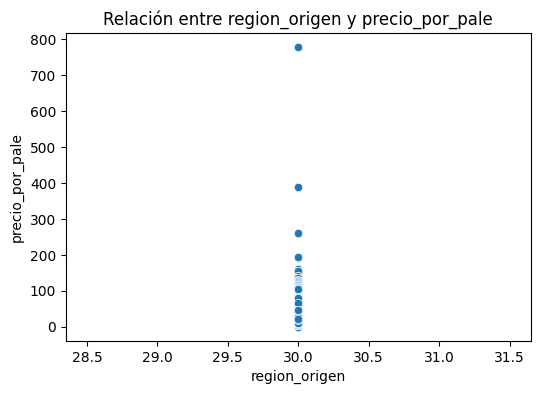

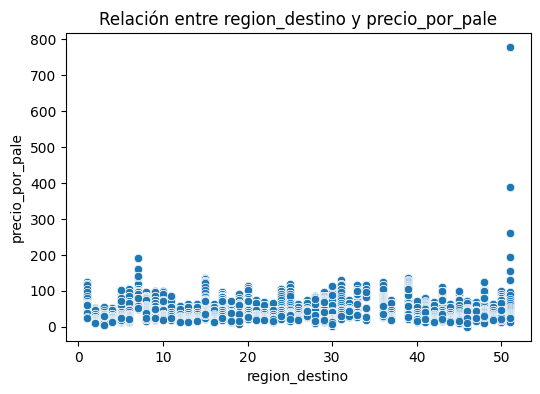

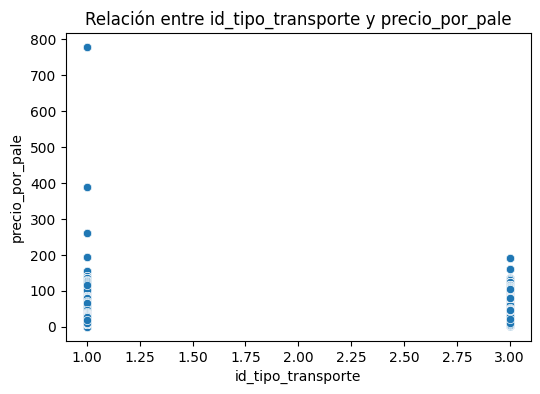

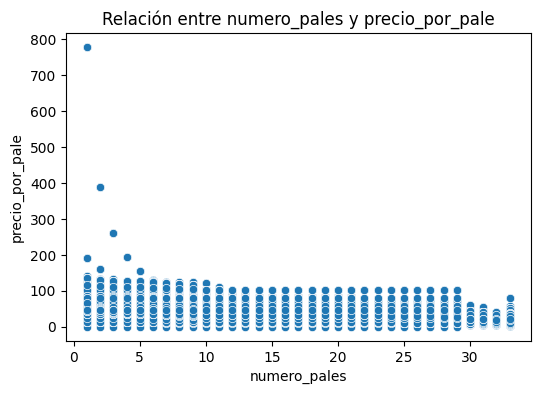

In [ ]:
# Crear un gráfico de dispersión para cada variable numérica vs precio_por_pale
numerical_columns = df_grouped_month.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_columns:
    if col != 'precio_por_pale':
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df_grouped_month[col], y=df_grouped_month['precio_por_pale'])
        plt.title(f'Relación entre {col} y precio_por_pale')
        plt.show()

- **Relación entre las variables independientes vs la dependiente:**
Según se observa en los gráficos, no se evidencia que exista una relacion lineal entre las variables independientes versus la variable objetivo. Esto nos da un indicio del tipo de modelo mas adecuado para realizar la predicción.  

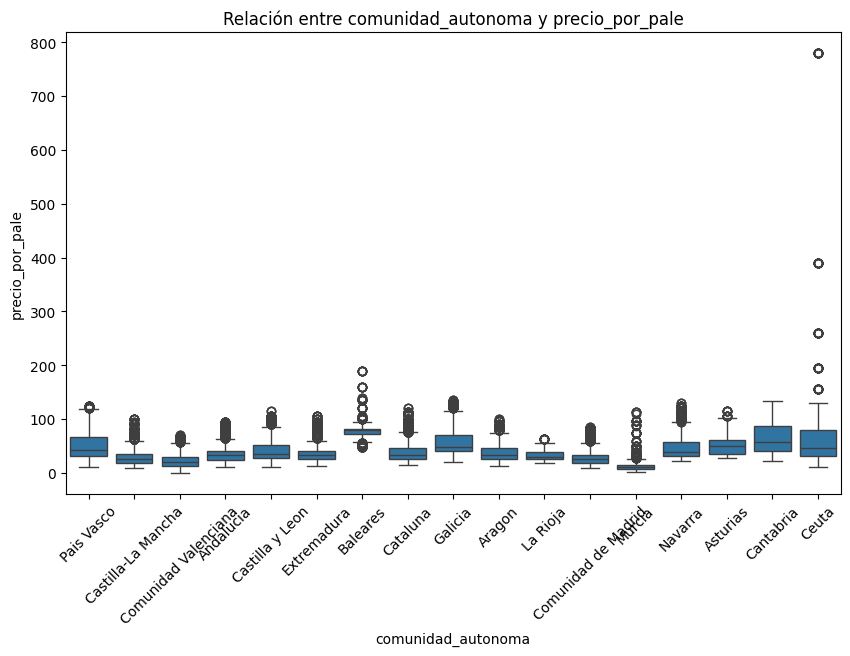

In [ ]:
categorical_columns = df_grouped_month.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_grouped_month[col], y=df_grouped_month['precio_por_pale'])
    plt.title(f'Relación entre {col} y precio_por_pale')
    plt.xticks(rotation=45)
    plt.show()

#### Agregamos el ipc

In [ ]:
df_grouped_month = df_grouped_month.merge(df_ipc, how='left', left_on=['year','month'], right_on=['year', 'month'])

#### Agregamos precio combustible

In [ ]:
df_grouped_month = df_grouped_month.merge(df_priceGas, how='left', left_on=['year','month'], right_on=['year', 'month'])

### Modificación de variables

#### Creación de dummies para id_tipo_transporte

In [ ]:
df_transporte_dummies = pd.get_dummies(df_grouped_month['id_tipo_transporte'], dtype=float, prefix='Transporte', drop_first=True) #CAMIÓN LONA (1), CAMIÓN FRIGO (3)

In [ ]:
df_grouped_month = pd.concat([df_grouped_month, df_transporte_dummies], axis=1)

#### Frequency encoder para region_destino

In [ ]:
fe = CountFrequencyEncoder(encoding_method='frequency', ignore_format=True)

In [ ]:
fe.fit(df_grouped_month[['region_destino']])

CountFrequencyEncoder(encoding_method='frequency', ignore_format=True)

In [ ]:
df_grouped_month['region_destino_freq'] = fe.transform(df_grouped_month[['region_destino']])

#### Frequency Encoder Comunidad Autonoma

In [ ]:
comunidadfe = CountFrequencyEncoder(encoding_method='frequency',ignore_format=True)

In [ ]:
fe.fit(df_grouped_month[['comunidad_autonoma']])

CountFrequencyEncoder(encoding_method='frequency', ignore_format=True)

In [ ]:
df_grouped_month['comunidad_autonoma_freq'] = fe.transform(df_grouped_month[['comunidad_autonoma']])

In [ ]:
# Crea la columna 'date' usando el primer día del mes para cada fila
df_grouped_month['date'] = pd.to_datetime(df_grouped_month[['year', 'month']].assign(day=1))

# Filtra las fechas menores a 01/08/2024
df_grouped_month = df_grouped_month[df_grouped_month['date'] < '2024-08-01']

In [ ]:
df_grouped_month.drop(columns=['date'], inplace=True)

### Modelo: RandomForestRegressor

In [ ]:
df_grouped_month.drop('comunidad_autonoma', axis=1, inplace=True)

#### Separamos por train y test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split (df_grouped_month.drop('precio_por_pale', axis=1),
                                                     df_grouped_month.precio_por_pale,
                                                     test_size = 0.20,
                                                     random_state = 93,
                                                    )

In [ ]:
# Crear el modelo RandomForestRegressor
model = RandomForestRegressor(n_estimators=200,
                              max_depth=9,
                              max_features='sqrt', #'sqrt', 'log2',
                              random_state=93)

In [ ]:
# Entrenar el modelo
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=200,
                      random_state=93)

In [ ]:
# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular RMSE (Raíz del Error Cuadrático Medio)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

# Calcular MAE (Error Absoluto Medio)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

# Calcular R² (Coeficiente de Determinación)
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

RMSE: 10.172351049467103
MAE: 6.359791678893171
R²: 0.8634778496305524


C:\Users\byron\Escritorio\Byron Caviedes\TFM UCM\TFM_AMC\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Evaluación del Modelo

Las métricas utilizadas para evaluar el desempeño del modelo son:

- **RMSE (Root Mean Squared Error)**: 10.17
  - El RMSE mide el error cuadrático medio, indicando que el modelo, en promedio, tiene un error de predicción de 10.17 unidades respecto a los valores reales.

- **MAE (Mean Absolute Error)**: 6.36
  - El MAE muestra el error absoluto promedio entre las predicciones del modelo y los valores reales, siendo 6.36 unidades el error promedio.

- **R² (Coeficiente de determinación)**: 0.86
  - El coeficiente de determinación indica que el modelo explica el 86% de la variabilidad observada en la variable dependiente.

En resumen, el modelo presenta un buen ajuste, con un coeficiente de determinación elevado y errores relativamente bajos en las predicciones.

In [ ]:
# Calcular el RMSE para el conjunto de entrenamiento (para comparar con el conjunto de prueba)
y_train_pred = model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"RMSE (entrenamiento): {rmse_train}")

# Calcular el RMSE para el conjunto de prueba (para detectar sobreajuste)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE (prueba): {rmse_test}")

RMSE (entrenamiento): 9.014245126753222
RMSE (prueba): 10.172351049467103


C:\Users\byron\Escritorio\Byron Caviedes\TFM UCM\TFM_AMC\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\byron\Escritorio\Byron Caviedes\TFM UCM\TFM_AMC\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Evaluación del RMSE en los Conjuntos de Entrenamiento y Prueba

Para evaluar el desempeño del modelo y detectar un posible sobreajuste, se calculó el **RMSE** (Root Mean Squared Error) para el conjunto de entrenamiento y el de prueba:

- **RMSE (entrenamiento)**: 9.01
  - El error cuadrático medio en el conjunto de entrenamiento es de 9.01, lo que indica que el modelo tiene un error promedio de 9.01 unidades al hacer predicciones sobre los datos con los que fue entrenado.

- **RMSE (prueba)**: 10.17
  - El error cuadrático medio en el conjunto de prueba es de 10.17, lo que significa que el modelo tiene un error promedio de 10.17 unidades al predecir sobre datos no vistos anteriormente.

#### Comparación y Posible Sobreajuste:
- La diferencia entre el RMSE del conjunto de entrenamiento (9.01) y el conjunto de prueba (10.17) es **ligeramente mayor en el conjunto de prueba**, lo que sugiere un **leve grado de sobreajuste**. Sin embargo, la diferencia no es muy grande, lo que indica que el modelo **generaliza bien** en datos no observados.

En general, el modelo presenta un rendimiento aceptable, con un error relativamente bajo tanto en el entrenamiento como en la prueba.


### Model: XGBoost

In [ ]:
# Separar los datos en entrenamiento y prueba
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df_grouped_month.drop('precio_por_pale', axis=1),
    df_grouped_month['precio_por_pale'],
    test_size=0.20,
    random_state=93
)

# Crear el modelo XGBoost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=93)

# Entrenar el modelo
model_xgb.fit(X_train2, y_train2)

# Realizar predicciones en el conjunto de prueba
y_pred2 = model_xgb.predict(X_test2)

# Calcular RMSE (Raíz del Error Cuadrático Medio)
rmse2 = mean_squared_error(y_test2, y_pred2, squared=False)
print(f"RMSE: {rmse2}")

# Calcular MAE (Error Absoluto Medio)
mae2 = mean_absolute_error(y_test2, y_pred2)
print(f"MAE: {mae2}")

# Calcular R² (Coeficiente de Determinación)
r2_2 = r2_score(y_test2, y_pred2)
print(f"R²: {r2_2}")


RMSE: 2.9230442149980425
MAE: 1.7844995388625995
R²: 0.9887272153378617


C:\Users\byron\Escritorio\Byron Caviedes\TFM UCM\TFM_AMC\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Evaluación del Modelo XGBoost

Las métricas utilizadas para evaluar el desempeño del modelo **XGBoost** son:

- **RMSE (Root Mean Squared Error)**: 2.92
  - El RMSE mide el error cuadrático medio. Un RMSE de 2.92 indica que, en promedio, el modelo tiene un error de predicción de 2.92 unidades, lo que muestra un **bajo error** y una buena capacidad predictiva.

- **MAE (Mean Absolute Error)**: 1.78
  - El MAE muestra el error absoluto promedio entre las predicciones del modelo y los valores reales. Un valor de 1.78 unidades refleja que el modelo tiene un **bajo error absoluto promedio**, lo que indica que es **preciso** en sus predicciones.

- **R² (Coeficiente de determinación)**: 0.99
  - El coeficiente de determinación de 0.99 sugiere que el modelo explica el **99% de la variabilidad** observada en la variable dependiente. Esto indica que el modelo tiene un **ajuste excelente** y que es muy eficaz en la predicción de los datos.

En resumen, el modelo **XGBoost** presenta un desempeño superior al de Random Forest Regressor, con un bajo error en las predicciones y una alta capacidad para explicar la variabilidad en los datos.

In [ ]:
print(df_grouped_month.columns)

Index(['year', 'month', 'region_origen', 'region_destino',
       'id_tipo_transporte', 'numero_pales', 'precio_por_pale', 'IPC_Mensual',
       'IPC_Anual', 'value', 'Transporte_3', 'region_destino_freq',
       'comunidad_autonoma_freq'],
      dtype='object')


## Creación Dataframe para la predicción

- En este paso procedemos a crear un dataframe con las fechas a predecir desde agosto 2024 a agosto 2025. Utilizamos itertools que nos permite realizar la multiplicacion de los distintos componentes que van a integran el dataframe como lo es el **rango de fechas**, **id_tipo_transporte**, **num_pales**, **provincias**.

In [ ]:
# Generar todas las fechas de 2025
fechas_2025 = pd.date_range(start="2024-08-01", end="2025-08-31").to_pydatetime().tolist()

# Tipos de transporte y número de palets
tipos_transporte = [1, 3]
num_pales = list(range(1, 34))

# Números de provincias (1 a 51)
provincias = list(range(1, 52))

# Crear combinaciones de fecha, tipo de transporte, número de pales y provincias
combinaciones = list(itertools.product(fechas_2025, tipos_transporte, num_pales, provincias))

# Crear el DataFrame
df_predict = pd.DataFrame(combinaciones, columns=["fecha", "id_tipo_transporte", "numero_pales", "region_destino"])

# Agregar la columna 'region_origen' con valor 30
df_predict['region_origen'] = 30


#### Creación de variables a partir de la fecha usando la función previamente creada transform_date

In [ ]:
transform_date(df_predict, 'fecha')

In [ ]:
df_predict

,fecha,id_tipo_transporte,numero_pales,region_destino,region_origen,year,month,day,week
0,2024-08-01,1,1,1,30,2024,8,1,31
1,2024-08-01,1,1,2,30,2024,8,1,31
2,2024-08-01,1,1,3,30,2024,8,1,31
3,2024-08-01,1,1,4,30,2024,8,1,31
4,2024-08-01,1,1,5,30,2024,8,1,31
...,...,...,...,...,...,...,...,...,...
1332931,2025-08-31,3,33,47,30,2025,8,31,35
1332932,2025-08-31,3,33,48,30,2025,8,31,35
1332933,2025-08-31,3,33,49,30,2025,8,31,35
1332934,2025-08-31,3,33,50,30,2025,8,31,35


In [ ]:
# Crear una columna de fechas a partir de 'year' y 'month'
df_priceGas['fecha'] = pd.to_datetime(df_priceGas[['year', 'month']].assign(day=1))

# Extraer el mes directamente de la columna 'month'
df_priceGas['month'] = df_priceGas['month']

# Calcular la media por mes (es decir, la media de todos los eneros, febreros, etc.)
media_por_mes = df_priceGas.groupby('month')['value'].mean()

# Generar las fechas para los meses futuros (de agosto 2024 a agosto 2025)
fechas_futuras = pd.date_range(start="2024-08-01", end="2025-08-31", freq='MS')

# Crear un DataFrame con las predicciones para los meses futuros
predicciones_combustible = pd.DataFrame({
    'fecha': fechas_futuras,
    'month': fechas_futuras.month
})

# Asignar la media correspondiente a cada mes futuro
predicciones_combustible['value'] = predicciones_combustible['month'].map(media_por_mes)


In [ ]:
predicciones_combustible

,fecha,month,value
0,2024-08-01,8,1.393420
1,2024-09-01,9,1.412140
2,2024-10-01,10,1.436580
3,2024-11-01,11,1.421280
4,2024-12-01,12,1.365940
5,2025-01-01,1,1.343800
6,2025-02-01,2,1.363933
7,2025-03-01,3,1.400450
8,2025-04-01,4,1.388833
9,2025-05-01,5,1.375583


In [ ]:
predicciones_combustible['year'] = predicciones_combustible['fecha'].dt.year

In [ ]:
# Extraer 'month' y 'year' en df_predict
df_predict['month'] = df_predict['fecha'].dt.month
df_predict['year'] = df_predict['fecha'].dt.year

# Crear 'month' y 'year' en predicciones_estacionales si no están presentes
#if 'month' not in predicciones_combustible.columns or 'year' not in predicciones_combustible.columns:
    #predicciones_combustible['month'] = predicciones_combustible['fecha'].dt.month
    #predicciones_combustible['year'] = predicciones_combustible['fecha'].dt.year

# Realizar el merge
df_merged = pd.merge(df_predict, predicciones_combustible[['month', 'year', 'value']], on=['month', 'year'], how='left')

In [ ]:
df_merged

,fecha,id_tipo_transporte,numero_pales,region_destino,region_origen,year,month,day,week,value
0,2024-08-01,1,1,1,30,2024,8,1,31,1.39342
1,2024-08-01,1,1,2,30,2024,8,1,31,1.39342
2,2024-08-01,1,1,3,30,2024,8,1,31,1.39342
3,2024-08-01,1,1,4,30,2024,8,1,31,1.39342
4,2024-08-01,1,1,5,30,2024,8,1,31,1.39342
...,...,...,...,...,...,...,...,...,...,...
1332931,2025-08-31,3,33,47,30,2025,8,31,35,1.39342
1332932,2025-08-31,3,33,48,30,2025,8,31,35,1.39342
1332933,2025-08-31,3,33,49,30,2025,8,31,35,1.39342
1332934,2025-08-31,3,33,50,30,2025,8,31,35,1.39342


#### Creación del estimado de IPC_Menssual e IPC_Anual mediante la media de los mismos meses de años anteriores

In [ ]:
# Crear una columna de fechas a partir de 'year' y 'month' en df_ipc
df_ipc['fecha'] = pd.to_datetime(df_ipc[['year', 'month']].assign(day=1))


In [ ]:
# Extraer el mes directamente de la columna 'month' en df_ipc (esto asegura que siempre tienes 'month')
df_ipc['month'] = df_ipc['month']

In [ ]:
# Calcular la media por mes para 'IPC_Mensual' y 'IPC_Anual'
media_ipc_mensual = df_ipc.groupby('month')['IPC_Mensual'].mean()
media_ipc_anual = df_ipc.groupby('month')['IPC_Anual'].mean()

In [ ]:
# Generar las fechas para los meses futuros (de agosto 2024 a agosto 2025)
fechas_futuras = pd.date_range(start="2024-08-01", end="2025-08-31", freq='MS')

In [ ]:
# Crear un DataFrame con las predicciones para los meses futuros
predicciones_ipc = pd.DataFrame({
    'fecha': fechas_futuras,
    'month': fechas_futuras.month
})

In [ ]:
# Asignar la media correspondiente a cada mes futuro para IPC_Mensual e IPC_Anual
predicciones_ipc['IPC_Mensual'] = predicciones_ipc['month'].map(media_ipc_mensual)
predicciones_ipc['IPC_Anual'] = predicciones_ipc['month'].map(media_ipc_anual)

In [ ]:
# Mostrar las predicciones
print(predicciones_ipc)

        fecha  month  IPC_Mensual  IPC_Anual
0  2024-08-01      8     0.413333   5.466667
1  2024-09-01      9     0.103333   5.466667
2  2024-10-01     10     0.823333   5.400000
3  2024-11-01     11    -0.053333   5.166667
4  2024-12-01     12     0.453333   5.100000
5  2025-01-01      1    -0.125000   3.975000
6  2025-02-01      2     0.380000   4.100000
7  2025-03-01      3     1.282500   4.400000
8  2025-04-01      4     0.575000   4.475000
9  2025-05-01      5     0.377500   4.550000
10 2025-06-01      6     0.820000   4.550000
11 2025-07-01      7    -0.327500   4.700000
12 2025-08-01      8     0.413333   5.466667


#### Agregamos IPC mensual y anual al dataframe df_merge que contiene los valores y fechas de las predicciones a realizar

In [ ]:
predicciones_ipc['year'] = predicciones_ipc['fecha'].dt.year

In [ ]:
df_merged = pd.merge(df_merged, predicciones_ipc[['month', 'year', 'IPC_Mensual', 'IPC_Anual']], on=['month', 'year'], how='left')

In [ ]:
df_merged

,fecha,id_tipo_transporte,numero_pales,region_destino,region_origen,year,month,day,week,value,IPC_Mensual,IPC_Anual
0,2024-08-01,1,1,1,30,2024,8,1,31,1.39342,0.413333,5.466667
1,2024-08-01,1,1,2,30,2024,8,1,31,1.39342,0.413333,5.466667
2,2024-08-01,1,1,3,30,2024,8,1,31,1.39342,0.413333,5.466667
3,2024-08-01,1,1,4,30,2024,8,1,31,1.39342,0.413333,5.466667
4,2024-08-01,1,1,5,30,2024,8,1,31,1.39342,0.413333,5.466667
...,...,...,...,...,...,...,...,...,...,...,...,...
1332931,2025-08-31,3,33,47,30,2025,8,31,35,1.39342,0.413333,5.466667
1332932,2025-08-31,3,33,48,30,2025,8,31,35,1.39342,0.413333,5.466667
1332933,2025-08-31,3,33,49,30,2025,8,31,35,1.39342,0.413333,5.466667
1332934,2025-08-31,3,33,50,30,2025,8,31,35,1.39342,0.413333,5.466667


#### Realizamos la adaptación de las frecuencias de region_destino y comunidad_autonoma para que no se pierda la información que esta nos aporta al modelo

In [ ]:
# Verificar las columnas presentes en el DataFrame
print("Columnas disponibles en el DataFrame:", df_grouped_month.columns)

# Crear una columna 'fecha' a partir de 'year' y 'month'
df_grouped_month['fecha'] = pd.to_datetime(df_grouped_month[['year', 'month']].assign(day=1))

# Ordenar los datos por 'region_destino' y 'fecha'
df_grouped_month = df_grouped_month.sort_values(['region_destino', 'fecha'])

# Definir el tamaño de la ventana de promedio móvil (por ejemplo, 12 meses)
window_size = 6

# Función para calcular el promedio móvil y predecir valores futuros
def predict_future(df, window_size, start_date, end_date):
    df = df.copy()

    # Calcular el promedio móvil para ambas columnas
    df['region_destino_freq_ma'] = df['region_destino_freq'].rolling(window=window_size).mean()
    df['comunidad_autonoma_freq_ma'] = df['comunidad_autonoma_freq'].rolling(window=window_size).mean()

    # Extraer el último mes registrado
    last_date = df['fecha'].max()

    # Crear un rango de fechas futuras
    future_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

    # Crear un DataFrame con las fechas futuras
    df_future = pd.DataFrame({'fecha': future_dates})
    df_future['year'] = df_future['fecha'].dt.year
    df_future['month'] = df_future['fecha'].dt.month

    # Obtener los últimos valores de promedio móvil
    last_values = df[['region_destino', 'region_destino_freq_ma', 'comunidad_autonoma_freq_ma']].dropna().iloc[-1]

    # Asignar los últimos valores a las fechas futuras
    df_future['region_destino_freq'] = last_values['region_destino_freq_ma']
    df_future['comunidad_autonoma_freq'] = last_values['comunidad_autonoma_freq_ma']

    return df_future

# Aplicar la función para cada 'region_destino' y concatenar los resultados
future_dfs = []
for region in df_grouped_month['region_destino'].unique():
    df_region = df_grouped_month[df_grouped_month['region_destino'] == region]
    df_future_region = predict_future(df_region, window_size, '2024-08-01', '2025-08-01')
    df_future_region['region_destino'] = region
    future_dfs.append(df_future_region)

# Concatenar todos los resultados futuros
df_future_all = pd.concat(future_dfs, ignore_index=True)

Columnas disponibles en el DataFrame: Index(['year', 'month', 'region_origen', 'region_destino',
       'id_tipo_transporte', 'numero_pales', 'precio_por_pale', 'IPC_Mensual',
       'IPC_Anual', 'value', 'Transporte_3', 'region_destino_freq',
       'comunidad_autonoma_freq'],
      dtype='object')


In [ ]:
df_future_all

,fecha,year,month,region_destino_freq,comunidad_autonoma_freq,region_destino
0,2024-08-01,2024,8,0.034954,0.095155,1
1,2024-09-01,2024,9,0.034954,0.095155,1
2,2024-10-01,2024,10,0.034954,0.095155,1
3,2024-11-01,2024,11,0.034954,0.095155,1
4,2024-12-01,2024,12,0.034954,0.095155,1
...,...,...,...,...,...,...
632,2025-04-01,2025,4,0.009510,0.009510,51
633,2025-05-01,2025,5,0.009510,0.009510,51
634,2025-06-01,2025,6,0.009510,0.009510,51
635,2025-07-01,2025,7,0.009510,0.009510,51


In [ ]:
df_merged = pd.merge(df_merged, df_future_all[['month', 'year', 'region_destino', 'region_destino_freq', 'comunidad_autonoma_freq']], on=['month', 'year', 'region_destino'], how='left')

In [ ]:
df_merged

,fecha,id_tipo_transporte,numero_pales,region_destino,region_origen,year,month,day,week,value,IPC_Mensual,IPC_Anual,region_destino_freq,comunidad_autonoma_freq
0,2024-08-01,1,1,1,30,2024,8,1,31,1.39342,0.413333,5.466667,0.034954,0.095155
1,2024-08-01,1,1,2,30,2024,8,1,31,1.39342,0.413333,5.466667,0.013019,0.086027
2,2024-08-01,1,1,3,30,2024,8,1,31,1.39342,0.413333,5.466667,0.034431,0.084258
3,2024-08-01,1,1,4,30,2024,8,1,31,1.39342,0.413333,5.466667,0.013019,0.142633
4,2024-08-01,1,1,5,30,2024,8,1,31,1.39342,0.413333,5.466667,0.018241,0.126585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332931,2025-08-31,3,33,47,30,2025,8,31,35,1.39342,0.413333,5.466667,0.014604,0.126585
1332932,2025-08-31,3,33,48,30,2025,8,31,35,1.39342,0.413333,5.466667,0.036511,0.095155
1332933,2025-08-31,3,33,49,30,2025,8,31,35,1.39342,0.413333,5.466667,0.009510,0.126585
1332934,2025-08-31,3,33,50,30,2025,8,31,35,1.39342,0.413333,5.466667,0.039950,0.058969


### Creación de dummies parala variable id_tipo_transporte

In [ ]:
df_transporte_dummies = pd.get_dummies(df_merged['id_tipo_transporte'], dtype=float, prefix='Transporte', drop_first=True) #CAMIÓN LONA (1), CAMIÓN FRIGO (3)

In [ ]:
df_merged = pd.concat([df_merged, df_transporte_dummies], axis=1)

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332936 entries, 0 to 1332935
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   fecha                    1332936 non-null  datetime64[ns]
 1   id_tipo_transporte       1332936 non-null  int64         
 2   numero_pales             1332936 non-null  int64         
 3   region_destino           1332936 non-null  int64         
 4   region_origen            1332936 non-null  int64         
 5   year                     1332936 non-null  int32         
 6   month                    1332936 non-null  int32         
 7   day                      1332936 non-null  int32         
 8   week                     1332936 non-null  UInt32        
 9   value                    1332936 non-null  float64       
 10  IPC_Mensual              1332936 non-null  float64       
 11  IPC_Anual                1332936 non-null  float64       
 12  

In [ ]:
df_merged['Transporte_3'].value_counts()

Transporte_3
0.0    666468
1.0    666468
Name: count, dtype: int64

In [ ]:
df_merged

,fecha,id_tipo_transporte,numero_pales,region_destino,region_origen,year,month,day,week,value,IPC_Mensual,IPC_Anual,region_destino_freq,comunidad_autonoma_freq,Transporte_3
0,2024-08-01,1,1,1,30,2024,8,1,31,1.39342,0.413333,5.466667,0.034954,0.095155,0.0
1,2024-08-01,1,1,2,30,2024,8,1,31,1.39342,0.413333,5.466667,0.013019,0.086027,0.0
2,2024-08-01,1,1,3,30,2024,8,1,31,1.39342,0.413333,5.466667,0.034431,0.084258,0.0
3,2024-08-01,1,1,4,30,2024,8,1,31,1.39342,0.413333,5.466667,0.013019,0.142633,0.0
4,2024-08-01,1,1,5,30,2024,8,1,31,1.39342,0.413333,5.466667,0.018241,0.126585,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332931,2025-08-31,3,33,47,30,2025,8,31,35,1.39342,0.413333,5.466667,0.014604,0.126585,1.0
1332932,2025-08-31,3,33,48,30,2025,8,31,35,1.39342,0.413333,5.466667,0.036511,0.095155,1.0
1332933,2025-08-31,3,33,49,30,2025,8,31,35,1.39342,0.413333,5.466667,0.009510,0.126585,1.0
1332934,2025-08-31,3,33,50,30,2025,8,31,35,1.39342,0.413333,5.466667,0.039950,0.058969,1.0


In [ ]:
# Variables a eliminar que no son parte de las variables origianles para el entrenamiento del modelo
columnas_a_eliminar = ['day', 'fecha', 'week']

In [ ]:
df_merged.drop(columns=columnas_a_eliminar, errors='ignore', inplace=True)

In [ ]:
# Se procede a ordenar las variables para la predicción
df_merged = df_merged[X_train.columns]

## Predicción usando el modelo Random Forest Regressor

In [ ]:
# Realizamos la predicción sobre nuestro dataframe de fechas futuras
predicciones = model.predict(df_merged)

In [ ]:
# Visualizamos las predicciones para un primer acercamiento
predicciones

array([54.96508778, 59.56780668, 51.90645283, ..., 34.5413408 ,
       31.98383237, 41.53440697])

In [ ]:
# Redondeamos a 2 decimales
predicciones_redondeadas = np.round(predicciones, decimals=2).astype(float)

In [ ]:
df_merged['prediccion_precio_por_pale'] = predicciones_redondeadas

C:\Users\byron\AppData\Local\Temp\ipykernel_27156\1734163779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['prediccion_precio_por_pale'] = predicciones_redondeadas


In [ ]:
df_merged

,year,month,region_origen,region_destino,id_tipo_transporte,numero_pales,IPC_Mensual,IPC_Anual,value,Transporte_3,region_destino_freq,comunidad_autonoma_freq,prediccion_precio_por_pale
0,2024,8,30,1,1,1,0.413333,5.466667,1.39342,0.0,0.034954,0.095155,54.97
1,2024,8,30,2,1,1,0.413333,5.466667,1.39342,0.0,0.013019,0.086027,59.57
2,2024,8,30,3,1,1,0.413333,5.466667,1.39342,0.0,0.034431,0.084258,51.91
3,2024,8,30,4,1,1,0.413333,5.466667,1.39342,0.0,0.013019,0.142633,67.01
4,2024,8,30,5,1,1,0.413333,5.466667,1.39342,0.0,0.018241,0.126585,73.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332931,2025,8,30,47,3,33,0.413333,5.466667,1.39342,1.0,0.014604,0.126585,31.12
1332932,2025,8,30,48,3,33,0.413333,5.466667,1.39342,1.0,0.036511,0.095155,41.01
1332933,2025,8,30,49,3,33,0.413333,5.466667,1.39342,1.0,0.009510,0.126585,34.54
1332934,2025,8,30,50,3,33,0.413333,5.466667,1.39342,1.0,0.039950,0.058969,31.98


In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

## Predicción usando el modelo XGBoost

In [ ]:
# Organizamos las columnas
df_merged = df_merged[X_train2.columns]

In [ ]:
# Realizamos la predicción
predicciones2 = model_xgb.predict(df_merged)

In [ ]:
# Primer vistazo de los valores predichos
predicciones2

array([54.139843, 44.73064 , 43.157883, ..., 23.197721, 25.510437,
       56.3281  ], dtype=float32)

In [ ]:
# Redondeamos a 2 decimales los precios
predicciones2_redondeadas = np.round(predicciones2, decimals=2).astype(float)

In [ ]:
# Agregamos los valores predicjos al dataframe de fechas futuras
df_merged['prediccion2_precio_por_pale'] = predicciones2_redondeadas

In [ ]:
df_merged

,year,month,region_origen,region_destino,id_tipo_transporte,numero_pales,IPC_Mensual,IPC_Anual,value,Transporte_3,region_destino_freq,comunidad_autonoma_freq,prediccion2_precio_por_pale
0,2024,8,30,1,1,1,0.41,5.47,1.39,0.00,0.03,0.10,54.14
1,2024,8,30,2,1,1,0.41,5.47,1.39,0.00,0.01,0.09,44.73
2,2024,8,30,3,1,1,0.41,5.47,1.39,0.00,0.03,0.08,43.16
3,2024,8,30,4,1,1,0.41,5.47,1.39,0.00,0.01,0.14,70.04
4,2024,8,30,5,1,1,0.41,5.47,1.39,0.00,0.02,0.13,100.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332931,2025,8,30,47,3,33,0.41,5.47,1.39,1.00,0.01,0.13,25.94
1332932,2025,8,30,48,3,33,0.41,5.47,1.39,1.00,0.04,0.10,27.87
1332933,2025,8,30,49,3,33,0.41,5.47,1.39,1.00,0.01,0.13,23.20
1332934,2025,8,30,50,3,33,0.41,5.47,1.39,1.00,0.04,0.06,25.51


### Comparación de Modelos

1. **Random Forest Regressor:**
   - **Semanal:**
     - **RMSE:** 9.75
     - **MAE:** 6.60
     - **R²:** 0.87
   - **Mensual:**
     - **RMSE:** 10.17
     - **MAE:** 6.36
     - **R²:** 0.86
   
   **Conclusión:** El rendimiento del Random Forest Regressor es ligeramente peor en el caso mensual en comparación con el semanal. El RMSE aumenta y el R² disminuye, indicando que el modelo puede no capturar bien las tendencias en los datos mensuales.

2. **XGBoost:**
   - **Semanal:**
     - **RMSE:** 2.57
     - **MAE:** 1.68
     - **R²:** 0.99
   - **Mensual:**
     - **RMSE:** 2.92
     - **MAE:** 1.78
     - **R²:** 0.99
   
   **Conclusión:** XGBoost muestra un rendimiento consistente entre los datos semanales y mensuales, con un ligero aumento en el RMSE y MAE en el contexto mensual. Sin embargo, el R² sigue siendo muy alto en ambos casos, indicando que XGBoost tiene una capacidad predictiva robusta en ambos contextos.

### Comparación entre Semanales y Mensuales

1. **Random Forest Regressor:**
   - **RMSE:** Aumenta de 9.75 (semanal) a 10.17 (mensual).
   - **MAE:** Disminuye ligeramente de 6.60 (semanal) a 6.36 (mensual).
   - **R²:** Disminuye ligeramente de 0.87 (semanal) a 0.86 (mensual).

   **Conclusión:** Random Forest tiene un rendimiento peor en el contexto mensual en comparación con el semanal. Esto podría indicar que el modelo es más adecuado para datos semanales o que la variabilidad en los datos mensuales no se captura bien.

2. **XGBoost:**
   - **RMSE:** Aumenta de 2.57 (semanal) a 2.92 (mensual).
   - **MAE:** Aumenta ligeramente de 1.68 (semanal) a 1.78 (mensual).
   - **R²:** Se mantiene alto en 0.99 tanto para semanal como mensual.

   **Conclusión:** XGBoost muestra un ligero aumento en el RMSE y MAE en los datos mensuales, pero su rendimiento sigue siendo excelente con un R² muy alto. Esto sugiere que el modelo se adapta bien a ambas frecuencias de datos.

## Consideraciones sobre el Sobreajuste

### Evaluación del Sobreajuste

- **XGBoost:**
  - **Observación:** XGBoost muestra un rendimiento muy alto en ambas frecuencias de datos (semanal y mensual) con valores de RMSE y MAE bajos y un R² muy alto. Aunque esto indica que el modelo está ajustado muy bien a los datos, es importante verificar si el rendimiento es consistente en datos no vistos para evitar el sobreajuste.
  - **Posible Sobreajuste:** Dado que XGBoost puede tener una tendencia a sobreajustar debido a su flexibilidad y capacidad para modelar complejidades, se debe validar el modelo con un conjunto de datos independiente o usar técnicas de validación cruzada para asegurarse de que el modelo no está capturando ruido en lugar de señales útiles.
  
- **Random Forest Regressor:**
  - **Observación:** Random Forest muestra un rendimiento más estable entre los datos semanales y mensuales, con un menor riesgo de sobreajuste debido a su naturaleza de ensamble y aleatorización.
  - **Posible Sobreajuste:** Aunque el modelo es menos propenso al sobreajuste, es esencial ajustar los parámetros como el número de árboles y la profundidad para garantizar que el modelo no esté ajustando demasiado a los datos de entrenamiento.
